Comparison of simulationed XYZ and transformed XYZ using Sovdat2019 matrix eq8 and eq 9


In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np

current_dir = os.getcwd()

sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
from src import *
sys.path.append(os.path.join(current_dir,'..','params'))
from load_params import *


In [2]:
# Ecostress simulation eval
ds_xyz = read_csv(os.path.join(current_dir,'..','Simulation','xyz_ECOSTRESS.csv'))
ds_rho_s2a = read_csv(os.path.join(current_dir,'..','Simulation','rho_ECOSTRESS_S2A.csv'))
ds_rho_s2b = read_csv(os.path.join(current_dir,'..','Simulation','rho_ECOSTRESS_S2B.csv'))
ds_rho_s2 = [ds_rho_s2a,ds_rho_s2b]
ds_rad_s2a = read_csv(os.path.join(current_dir,'..','Simulation','rad_ECOSTRESS_S2A.csv'))
ds_rad_s2b = read_csv(os.path.join(current_dir,'..','Simulation','rad_ECOSTRESS_S2B.csv'))
ds_rad_s2 = [ds_rad_s2a,ds_rad_s2b]
s2_bnames = ['B4','B3','B2']
xyz_names = ['X','Y','Z']
sensor_names = ['S2A','S2B']

# load test fname list
f = open(os.path.join(current_dir,'..','Simulation','fnames_test.txt'),"r")
fnames_test = f.read().splitlines()
f.close()

def get_inds(fnames,fnames_sub):
    inds = []
    for fname in fnames_sub:
        inds.append(fnames.index(fname))
    return inds

inds = get_inds(ds_xyz['NAME'],fnames_test)

def build_sub_dataset(ds,inds):
    mydict = {}
    for key in list(ds.keys()):
        mydict[key] = np.array(ds[key])[inds]
    return mydict

ds_xyz_sub = build_sub_dataset(ds_xyz,inds)

ds_rho_s2_sub = []
for ds in ds_rho_s2:
    ds_rho_s2_sub.append(build_sub_dataset(ds,inds))

ds_rad_s2_sub = []
for ds in ds_rad_s2:
    ds_rad_s2_sub.append(build_sub_dataset(ds,inds))

Eq8
Rho to XYZ


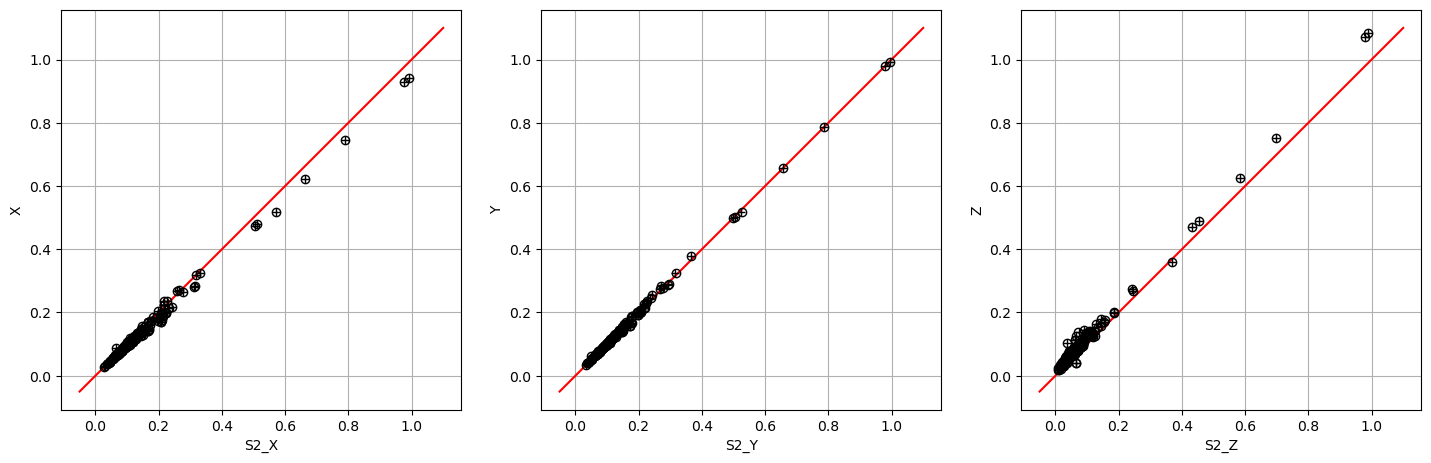

Rad to XYZ


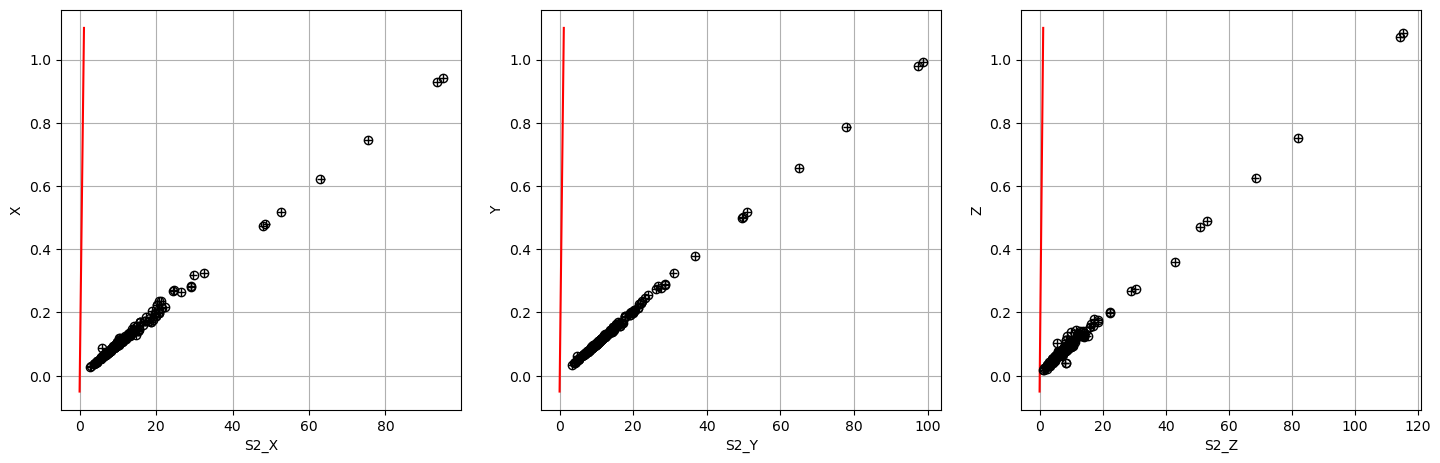

In [7]:
def s2_to_xyz(ds_s2,matrix):
    s2_bnames = ['B4','B3','B2']
    A = np.empty([len(ds_s2['B4']),3],dtype=float)
    for i in range(len(s2_bnames)):
            A[:,i] = ds_s2[s2_bnames[i]]
    B = A @ matrix
    
    return B

def plot_scatter(ds_s2,ds_xyz,matrix):
    xyz_s2 = []
    for s in range(2):
        xyz = s2_to_xyz(ds_s2[s],matrix)
        xyz_s2.append(xyz)

    X = []
    Y = []
    for i in range(3):
        xs = []
        ys = []
        xs.append([-0.05,1.1])
        ys.append([-0.05,1.1])
        for s in range(2):
            x = list(xyz_s2[s][:,i])
            y = ds_xyz[xyz_names[i]]
            xs.append(x)
            ys.append(y)
        X.append(xs)
        Y.append(ys)

    xlabels = ['S2_X','S2_Y','S2_Z']
    ylabels = ['X','Y','Z']

    fmts = [['r-','ko','k+']]*len(s2_bnames)
    solid_markers = [[False,False,False]]*len(X)
    grid = [True]*len(X)
    # xlims = [(-0.05,1.2)]*len(X)
    xlims = None
    ylims = xlims
    plot_figures(X, Y, xlabels=xlabels, ylabels=ylabels, titles=None, ncol=3, cell_width=4, cell_height=4,
                     left_margin=0.5, right_margin=0.5, top_margin=0.5, bottom_margin=0.5,
                     h_margin=0.8, v_margin=0.5, fmts=fmts, grid=grid, solid_markers=solid_markers, 
                     legends=None, dstfile=None,xlims=xlims,ylims=ylims)


print('Eq8')
matrix = matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq8
print('Rho to XYZ')
plot_scatter(ds_rho_s2_sub,ds_xyz_sub,matrix)
print('Rad to XYZ')
plot_scatter(ds_rad_s2_sub,ds_xyz_sub,matrix)

# print('Eq9')
# matrix = matrix_s2l2ab4b3b2_to_xyzd65_sovdat2019_eq9
# print('Rho to XYZ')
# plot_scatter(ds_rho_s2_sub,ds_xyz_sub,matrix)
# print('rad to XYZ')
# plot_scatter(ds_rad_s2_sub,ds_xyz_sub,matrix)